# H1: Human 7DoF Reach and Grasp

H1 is a dataset that was collected for open loop calibration of a BCI for robot arm control. The dataset contains neural activity of a human participant as attempting a reach and grasp with their right hand according to visually cued motion for 7 degrees of freedom (DoF). The visual cue was a screen illustrating the desired motion on a virtual arm, and the participant has had practice following these cues to calibrate similar decoders before this dataset was collected.

The data was collected by Sharlene Flesher and Jen Collinger as part of their study on the effects of stimulation for control ([Flesher 21]((https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8715714/))), but these datasets do not include stimulation. A protocol similar to the one used here is described e.g. in [Collinger 13](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(12)61816-9/fulltext), [Wodlinger 14](https://iopscience.iop.org/article/10.1088/1741-2560/12/1/016011#jne505388f1).

## Task 
The virtual arm movement occurs in phases as indicated in the following screenshot. Each phase begins with a presentation of a combo visual and word cue for a particular movement, so the participant can prepare an imagined movement, and an audio go cue to execute the imagined movement.

The screenshot is taken from the Virtual Integration Environment developed by Johns Hopkins University Applied Physics Laboratory ([Wodlinger 14](https://iopscience.iop.org/article/10.1088/1741-2560/12/1/016011)), and Supplement 5 demonstrates a full video of this task. Note that the actual configuration of the virtual environment differed slightly from samples shown.

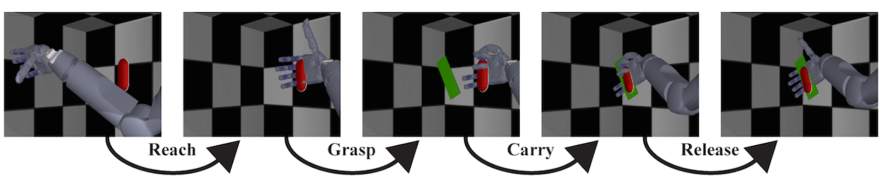

In [2]:
from IPython.display import display, Image
display(Image(filename="data_demos/imgs/h1.png", embed=True))

## Dataset statistics

Training datasets occur over a few days. One test set is available...
I should really use the 2 x 2 x 2 set... is it the one with missing...?

# TODO gross statistics, trialized structur  e..
- 7 DoF: 3D position of the hand, 3D orientation of the hand, 1D grasp aperture
    - 50Hz upsampled to 100Hz
- 176 motor units. Thresholds determined on daily basis.
- Train, short, and long test phases illustrated on dataset timelines

## Trial structure

## Neural activity
Multi-unit activity